In [1]:
import numpy as np

import sys
sys.path.append('../')
import mapache

from bs4 import BeautifulSoup, NavigableString
import urllib.request

from tqdm import tqdm

import datetime

from dateutil.parser import parser

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Parsing the wikipedia polls page

A party is created from its name(s) and the party logo, that will be used to represent the party

Name: Ciudadanos
Full name: Ciudadanos - Partido de la Ciudadanía
Short name: C's


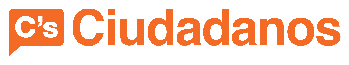

In [2]:
ciudadanos = mapache.Party('Ciudadanos',
                   'https://www.ciudadanos-cs.org/var/public/sections/page-imagen-del-partido/logo-ciudadanos.jpg',
                   short_name = 'C\'s',
                   full_name = 'Ciudadanos - Partido de la Ciudadanía')

ciudadanos.show()

We recover the table with all the polls for the 2016 Spanish National elections

In [3]:
wiki = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2016"
page = urllib.request.urlopen(wiki)
soup = BeautifulSoup(page, "html.parser")
tables = soup.findAll("table", class_="wikitable")


## Creating the parties

The first row of the table is parsed to get the name and parties. Party logos are extracted from their wikipedia pages

In [4]:
def from_wiki_table(table):
    spanish_parties = mapache.PartySet()
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")    
    for c in tqdm(cells[2:-3]):
        
        #From each cell we recover the name, logo and wikipedia url of the party
        url = "http://wikipedia.org" + c.find("a").attrs["href"]
        small_logo = "http:" + c.find("img").attrs["src"]
        name = c.find("a").attrs["title"]
        
        # The party wiki page is fetched to get the full name and full logo
        page = urllib.request.urlopen(url)
        party_soup = BeautifulSoup(page, "html.parser")
        infobox = party_soup.find("table", {"class": "infobox vcard"})
        big_logo = "http:" + infobox.find("td", {"class":"logo"}).find("img").attrs["src"]
        
        # If both the English and Spanish name are present the Spanish one
        # has class "nickname", otherway it has "fn org"
        full_name = infobox.find("span", {"class":"nickname"})
        if full_name:
            full_name = full_name.text
        else:
            full_name = infobox.find("span", {"class":"fn org"}).text


        # With the data obtained from the wiki a new party is created and added
        # to the party set
        party = mapache.Party(name, big_logo,
                       # The abbreviation/short name will be created automatically  
                       # if the name provided is too long                       
                       full_name = full_name,
                       small_logo=small_logo)

        spanish_parties.add(party)
        
    return spanish_parties

In [5]:
spanish_parties = from_wiki_table(tables[0])

100%|██████████| 7/7 [00:07<00:00,  1.09s/it]



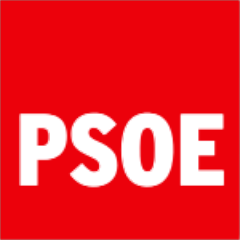
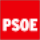
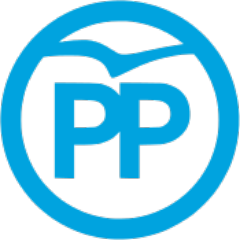
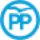
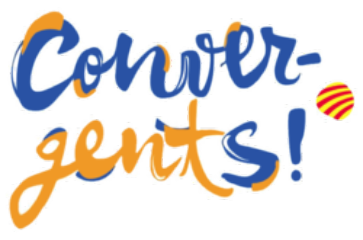
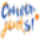
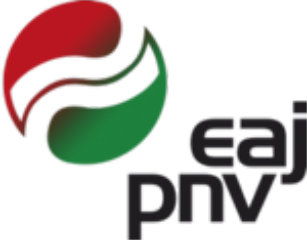
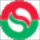
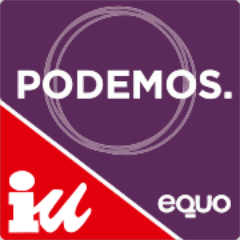
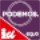
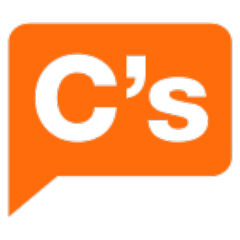
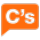
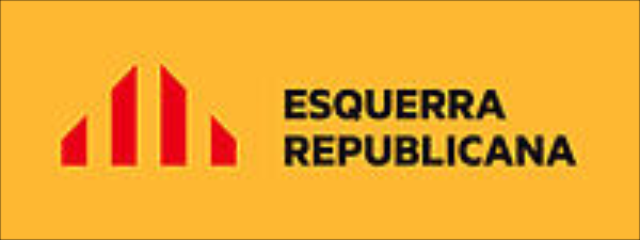
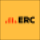

In [6]:
spanish_parties.show_parties()

In the all polls the coalition 'Unidos Podemos' was not together, we can add the parties of the coalition so they are recognized in all polls

In [7]:
spanish_parties_old = from_wiki_table(tables[1])

100%|██████████| 8/8 [00:09<00:00,  1.13s/it]



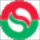
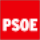
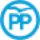
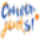
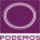
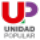
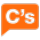
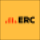

In [8]:
spanish_parties_old.show_parties(small=True)


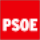
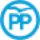
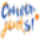
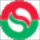
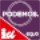
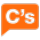
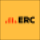

In [9]:
spanish_parties.show_parties(small=True)

Name: Podemos+allies
Full name: Podemos
Short name: POD


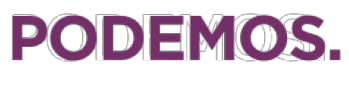

In [10]:
spanish_parties_old['POD'].show()

In [11]:
spanish_parties_old.parties

{"C'S": <mapache.core.Party at 0x7f6e55d44dd8>,
 'CDC': <mapache.core.Party at 0x7f6e54758b00>,
 'ERC': <mapache.core.Party at 0x7f6e5475e278>,
 'IU-': <mapache.core.Party at 0x7f6e548e6a20>,
 'PNV': <mapache.core.Party at 0x7f6e563cb240>,
 'POD': <mapache.core.Party at 0x7f6e55d3b668>,
 'PP': <mapache.core.Party at 0x7f6e55aabba8>,
 'PSOE': <mapache.core.Party at 0x7f6e55d489b0>}

In [12]:
coalition_party_names = ['POD', 'IU-']

In [13]:
for p in coalition_party_names:
    spanish_parties['UP'].add_to_coalition(spanish_parties_old[p])

In [14]:
spanish_parties_old.parties['POD']

Name: Unidos Podemos
Full name: Unidos Podemos
Short name: UP
In this coalition:  ['Podemos+allies', 'IU-UPeC']


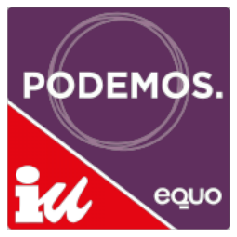

In [15]:
spanish_parties['UP'].show()


## Parsing the polls

## We parse the Wikipedia page to extract each poll and create a _PollsList_ of _Polls_

In [16]:
from dateutil.parser import parse

In [17]:
def poll_from_table(table):
    
    polls = mapache.PollsList("Encuestas")
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")  
    party_names = []
    
    for c in cells[2:-3]:
        name = c.find("a").attrs["title"]
        party_names.append(name)

    rows = table.findAll("tr")[2:]
    for row in tqdm(rows):
        
        cells = row.findAll("td")
        if len(cells) <= 3:
            continue
            
        pollster = cells[0].text
        err = cells[-3].text
        if err:
            err = float(err[1:].split(' ')[0])

        date = cells[1].text
        date = parse(date)            


        votes = {}
        for i, p in enumerate(cells[2: -3]):
            v = p.text
            if v:
                v = float(v)
                votes[party_names[i]] = v

        poll = mapache.Poll(votes, date, pollster, err)
                
        polls.add(poll)
        
    return polls


In [18]:
polls = poll_from_table(tables[0])

print('{0} polls loaded'.format(len(polls.polls)))

100%|██████████| 33/33 [00:00<00:00, 2642.51it/s]

33 polls loaded


In [19]:
polls.polls[2].print()

Pollster: NC Report
Date: 2016-05-27 00:00:00
Error: 2.2%  
--------------------
Unidos Podemos: 24.7
PSOE: 21.3
ERC: 2.2
CDC: 1.6
C's: 14.2
PNV: 1.1
PP: 30.5


We add the old polls as well (from a different table):

In [20]:
old_polls = poll_from_table(tables[1])

polls.add(old_polls)

print('{0} polls loaded'.format(len(old_polls.polls)))

100%|██████████| 78/78 [00:00<00:00, 4279.51it/s]

76 polls loaded


## Matching polls to parties

As it is likely that the all polls will not have the same name for a party, *mapache* can match a name to the closest party

In [21]:
name = 'ciutadans'
matched = spanish_parties.match(name)

print('\'{0}\' matched to \'{0}\', which included the names: {2}'.format(name, matched.name,
                                                                        matched.get_all_names()))



'ciutadans' matched to 'ciutadans', which included the names: ['Ciudadanos', "C's", "C'S"]


Using name matching it is possible to get all poll results of a party

In [22]:
spanish_parties.match('unidad popular')


In [23]:
old_polls.polls[1].print()

Pollster: Celeste-Tel[CV]
Date: 2016-05-06 00:00:00
Error: 3.1%  
--------------------
IU-UPeC: 5.2
PSOE: 21.7
C's: 15.2
PP: 28.8
Podemos+allies: 19.7


In [24]:
# Fix bug for parties = {'pp': 'blue', 'psoe': 'red', 'up':'purple', 'ciudadanos':'orange'} !!!

0.5

../mapache/core.py:188: UserWarning: Party was not found, returning closest match
  warnings.warn('Party was not found, returning closest match')


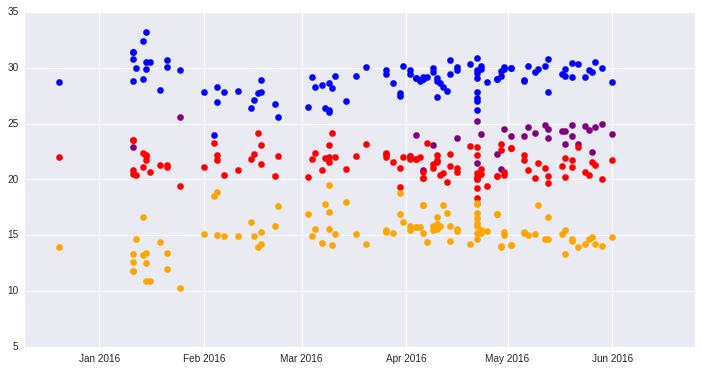

In [27]:
plt.rcParams['figure.figsize'] = (12, 6)

parties = {'pp': 'blue', 'psoe': 'red', 'up':'purple', 'ciudadanos':'orange'}

for k in parties:
    party_polls = polls.get_party(spanish_parties[k], join_coalitions=False)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=parties[k], s=40)



If __join_coallitions=False__, the votes of the parties being part of a coallition are not sum together, to get them we can set it to true.

../mapache/core.py:188: UserWarning: Party was not found, returning closest match
  warnings.warn('Party was not found, returning closest match')


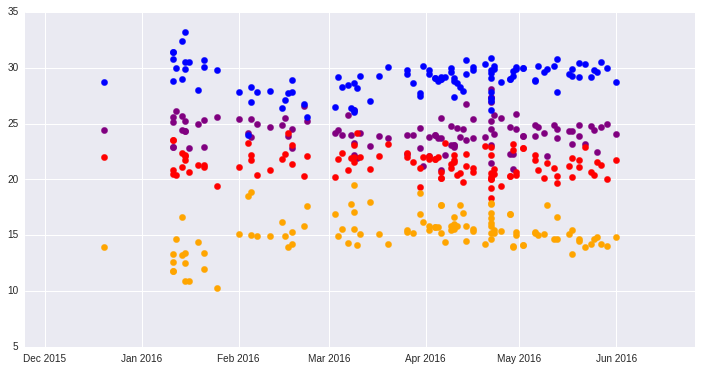

In [28]:
plt.rcParams['figure.figsize'] = (12, 6)

parties = {'pp': 'blue', 'psoe': 'red', 'up':'purple', 'ciudadanos':'orange'}

for k in parties:
    party_polls = polls.get_party(spanish_parties[k], join_coalitions=True)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=parties[k], s=40)


## Visualizing a poll

In [35]:
poll=polls.polls[0]

## Visualizing several polls

We visualize the top main parties

__TODO__: *Automatically select the top N parties* 

In [ ]:
main_parties = ['PP', 'PSOE', 'Podemos', 'C\'s']

In [42]:
spanish_parties.get()